# Simulations TVA - Budget 2025 : Chapitre socio-fiscal

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import wquantiles 

from tqdm import tqdm
from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    df_weighted_average_grouped,
    wavg)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Calage_consommation_bdf import new_get_inflators_by_year
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame

In [2]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_ht_tva_taux_plein',
'depenses_ht_tva_taux_intermediaire',
'depenses_ht_tva_taux_reduit',
'depenses_ht_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'depenses_tot',
'tva_total',
'rev_disponible',
 'niveau_de_vie',
 'niveau_vie_decile',
 'ocde10',
 'pondmen',
 'nactifs',
 'npers',
 'identifiant_menage']

In [2]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [3]:
year = 2024
data_year = 2017
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflators_by_year = new_get_inflators_by_year(rebuild = True, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

c:\users\veve1\documents\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\TVA_Herve_IPP\Calage_consommation_bdf.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_bdf_postes_cn[poste] = 0
c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\openfisca_core\holders\holder.py:230: Warning: You cannot set a value for the variable poste_09_6_1_2, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(


## Recalage sur les niveaux de vie dans TaxIPP

In [5]:
data = {"quantile_indiv_niveau_vie": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'rev_disponible_taxipp' : [
        17164,
        28523,
        32785,
        37962,
        42484,
        47179,
        53571,
        60538,
        72271,
        121762,
    ],
    'niveau_de_vie_taxipp' : [
        8082,
        14242,
        17617,
        20598,
        23339,
        26229,
        29506,
        33734,
        40382,
        69374
    ]
}
df_taxipp = pd.DataFrame(data)

In [6]:
df_taxipp

,quantile_indiv_niveau_vie,rev_disponible_taxipp,niveau_de_vie_taxipp
0,1,17164,8082
1,2,28523,14242
2,3,32785,17617
3,4,37962,20598
4,5,42484,23339
5,6,47179,26229
6,7,53571,29506
7,8,60538,33734
8,9,72271,40382
9,10,121762,69374


In [7]:
# On se place au niveau individu (en dupliquant les observations de chaque ménage) et on calcule des déciles de niveau de vie individuels

baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
baseline_indiv = baseline_menage.loc[baseline_menage.index.repeat(baseline_menage['npers'])]
baseline_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(baseline_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = baseline_indiv['pondmen'], return_quantiles= False)
baseline_indiv['quantile_indiv_niveau_vie'] = baseline_indiv['quantile_indiv_niveau_vie'].astype(int)

df_decile_indiv = baseline_indiv[['identifiant_menage','quantile_indiv_niveau_vie']].drop_duplicates() # On garde le lien identifiant ménage - quantil_indiv_niveau_vie pour plus tard

In [8]:
baseline_by_decile = df_weighted_average_grouped(dataframe = baseline_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['rev_disponible','niveau_de_vie']
                                                    )

baseline_by_decile = baseline_by_decile.merge(df_taxipp, how = 'inner', on = 'quantile_indiv_niveau_vie')
baseline_by_decile['coeff_calage'] = baseline_by_decile['rev_disponible_taxipp'] / baseline_by_decile['rev_disponible']

In [9]:
baseline_by_decile

,quantile_indiv_niveau_vie,rev_disponible,niveau_de_vie,rev_disponible_taxipp,niveau_de_vie_taxipp,coeff_calage
0,1,25928.896074,13169.605807,17164,8082,0.661964
1,2,38386.813041,19881.068774,28523,14242,0.743042
2,3,43950.252978,24022.842824,32785,17617,0.745957
3,4,50662.486034,27726.100521,37962,20598,0.749312
4,5,56469.521240,31233.648930,42484,23339,0.752335
5,6,62927.754364,34895.352100,47179,26229,0.749733
6,7,70233.377372,38921.835167,53571,29506,0.762757
7,8,79162.744661,44181.255864,60538,33734,0.764728
8,9,93326.521397,52241.763156,72271,40382,0.774389
9,10,141622.511358,80573.514129,121762,69374,0.859764


In [10]:
# On recale les revenus disponible dans les données qui serviront d'entrée au modèle 
input_data_frame = get_input_data_frame(2017)
input_data_frame = input_data_frame.merge(df_decile_indiv, how = 'right', on = 'identifiant_menage')
input_data_frame = input_data_frame.merge(baseline_by_decile[['quantile_indiv_niveau_vie','coeff_calage']], how = 'left', on = 'quantile_indiv_niveau_vie')
input_data_frame['rev_disponible'] = input_data_frame['rev_disponible'] * input_data_frame['coeff_calage']
input_data_frame.drop(['quantile_indiv_niveau_vie','coeff_calage'], axis = 1, inplace = True)

## Recalage sur les 13 Milliards

On recale également les dépenses pour atteindre un montant de dépenses hors-taxes de 60,5% de 1 300 Milliards. De sorte que le rendement du point de TVA soit de 13 Milliards

In [11]:
depenses_ht_totales = (survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_plein', use_baseline = True, period = year) +
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_intermediaire', use_baseline = True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_reduit', use_baseline = True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_super_reduit', use_baseline = True, period = year)
 )
depenses_ht_totales
tva_total = survey_scenario.compute_aggregate(variable = 'tva_total', use_baseline = True, period = year)
emplois_taxables_tot = 13E11
part_conso_menages = 0.605
coeff = part_conso_menages * emplois_taxables_tot / depenses_ht_totales
coeff

0.8607480864846293

In [12]:
tva_total / depenses_ht_totales

0.13663706258635036

In [13]:
new_inflators_2024 = { k:v if k in ['loyer_impute','rev_disp_yc_loyerimpute','rev_disponible'] else  v*coeff 
                      for k,v in inflators_by_year[2024].items()}
inflation_kwargs = dict(inflator_by_variable = new_inflators_2024)

survey_scenario = SurveyScenario.create(
    input_data_frame = input_data_frame, # La base d'entrée a des revenus disponibles / niveaux de vie calés sur ceux de taxipp
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    )

In [14]:
recolte_taux_plein = survey_scenario.compute_aggregate(variable='tva_taux_plein', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_inter = survey_scenario.compute_aggregate(variable='tva_taux_intermediaire', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_reduit = survey_scenario.compute_aggregate(variable='tva_taux_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_super_reduit = survey_scenario.compute_aggregate(variable='tva_taux_super_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9

In [15]:
recolte_taux_plein + recolte_taux_inter + recolte_taux_reduit + recolte_taux_super_reduit

7.849394042285159

In [16]:
survey_scenario.compute_aggregate(variable ='tva_total', filter_by = 'rev_disponible > 0', use_baseline= True, period = year) * 1e-9

107.24413819412776

In [17]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage   = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = False, period = 2024)['menage']

In [18]:
difference_menage = pd.DataFrame()
baseline_variables = ['depenses_tot','rev_disponible','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers','identifiant_menage'] 
difference_menage[baseline_variables] = baseline_menage[baseline_variables]

difference_menage['depenses_totales'] = baseline_menage['depenses_totales'] - reform_menage['depenses_totales']
difference_menage['depenses_tot_par_uc'] = difference_menage['depenses_tot'] / difference_menage['ocde10']
difference_menage['depenses_totales_par_uc'] = difference_menage['depenses_totales'] / difference_menage['ocde10']

for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage['actifs'] = (difference_menage['nactifs'] >= 1)

### Passage base ménages -> base individuelle

In [19]:
difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)
difference_menage['npers'].sum(), len(difference_indiv)

(28533, 28533)

### Les effets d'une hausse de TVA par décile de niveau de vie

In [ ]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   difference_indiv['depenses_par_uc_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['ocde10']

difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )

NameError: name 'difference_indiv' is not defined

In [1]:
difference_by_decile

NameError: name 'difference_by_decile' is not defined

In [22]:
difference_by_decile['taux_epargne'] = 1 - difference_by_decile['depenses_tot'] / difference_by_decile['rev_disponible']
difference_by_decile[['taux_epargne']]

,taux_epargne
quantile_indiv_niveau_vie,
1,-0.666788
2,-0.120180
3,-0.046288
4,-0.036684
5,0.006952
6,-0.029144
7,0.104178
8,0.101746
9,0.190638


In [23]:
for taux in liste_taux:
   difference_by_decile['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile['niveau_de_vie'] * 100
difference_by_decile['Taux_effort_total'] = difference_by_decile['depenses_totales_par_uc'] / difference_by_decile['niveau_de_vie'] * 100

In [24]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot, bootstrap_weighted_mean_by_decile

In [25]:
df = difference_menage.merge(df_decile_indiv, how = 'left', on = 'identifiant_menage')
results_bootstrap_all = bootstrap_weighted_mean_by_decile(df, 'pondmen', 'quantile_indiv_niveau_vie', B = 10000)

  6%|▋         | 628/10000 [01:05<16:24,  9.52it/s]


KeyboardInterrupt: 

In [ ]:
errors_all = pd.DataFrame(pd.DataFrame(results_bootstrap_all).std(axis = 0))
errors_all = errors_all.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_all = errors_all.reset_index().rename({'index' : 'quantile_indiv_niveau_vie'}, axis = 1).set_index('quantile_indiv_niveau_vie')
errors_all['errors'] = 1.96 * errors_all['std']
difference_by_decile = difference_by_decile.merge(errors_all, left_index = True, right_index = True)

In [26]:
difference_by_decile

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,taux_epargne,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
quantile_indiv_niveau_vie,,,,,,,,,,,,,,,
1,28608.753397,15432.924934,-103.425930,17164.000001,8717.807090,-53.424932,-16.187728,-32.501297,-1.311959,-0.666788,-0.612825,-0.185686,-0.372815,-0.015049,-1.186376
2,31950.891038,16985.703989,-115.980057,28522.999963,14772.461683,-62.170591,-16.666130,-35.138938,-2.004451,-0.120180,-0.420855,-0.112819,-0.237868,-0.013569,-0.785110
3,34302.544848,18964.719908,-127.520398,32784.999958,17920.008340,-68.673991,-19.415753,-37.509790,-1.920917,-0.046288,-0.383225,-0.108347,-0.209318,-0.010719,-0.711609
4,39354.582370,21674.541913,-147.162481,37961.999890,20775.495004,-78.354059,-22.579793,-43.924260,-2.304373,-0.036684,-0.377147,-0.108685,-0.211423,-0.011092,-0.708346
5,42180.984377,23545.022713,-162.996459,42476.263015,23497.779159,-83.875088,-30.889409,-45.380053,-2.851927,0.006952,-0.356949,-0.131457,-0.193125,-0.012137,-0.693668
6,48563.205922,26756.524621,-189.866766,47187.950425,26163.268213,-90.099230,-47.054297,-49.694205,-3.019014,-0.029144,-0.344373,-0.179849,-0.189939,-0.011539,-0.725700
7,47990.074706,26715.409615,-187.134340,53570.999902,29687.902041,-97.891185,-33.750353,-52.719707,-2.773043,0.104178,-0.329734,-0.113684,-0.177580,-0.009341,-0.630339
8,54378.503222,30426.568475,-218.273525,60538.000046,33786.661598,-108.946164,-44.061671,-61.901849,-3.363841,0.101746,-0.322453,-0.130411,-0.183214,-0.009956,-0.646035
9,58493.429337,32811.379256,-238.415384,72271.000168,40455.429137,-118.593741,-51.166017,-64.206144,-4.449443,0.190638,-0.293147,-0.126475,-0.158708,-0.010998,-0.589329


In [ ]:
bottom_50 = pd.DataFrame(difference_by_decile.loc[difference_by_decile.index < 6, ['depenses_totales_par_uc','niveau_de_vie','Taux_effort_total']].mean(axis = 0)).T
bottom_50['taux_effort_moyen'] = bottom_50['depenses_totales_par_uc'] / bottom_50['niveau_de_vie'] * 100
bottom_50

In [37]:
bottom_50

,depenses_totales_par_uc,niveau_de_vie,Taux_effort_total,taux_effort_moyen
0,-131.417065,17136.710255,-0.817022,-0.766875


In [43]:
difference_by_decile.loc[difference_by_decile.index.isin([6,7,8,9]), ['depenses_totales_par_uc','niveau_de_vie','Taux_effort_total']]

,depenses_totales_par_uc,niveau_de_vie,Taux_effort_total
quantile_indiv_niveau_vie,,,
6,-189.866766,26163.268213,-0.725700
7,-187.134340,29687.902041,-0.630339
8,-218.273525,33786.661598,-0.646035
9,-238.415384,40455.429137,-0.589329


In [ ]:
middle_40 = pd.DataFrame(difference_by_decile.loc[difference_by_decile.index.isin([6,7,8,9]), ['depenses_totales_par_uc','niveau_de_vie','Taux_effort_total']].mean(axis = 0)).T
middle_40['taux_effort_moyen'] = middle_40['depenses_totales_par_uc'] / middle_40['niveau_de_vie'] * 100
middle_40

,depenses_totales_par_uc,niveau_de_vie,Taux_effort_total,taux_effort_moyen
0,-208.422504,32523.315247,-0.64785,-0.64084


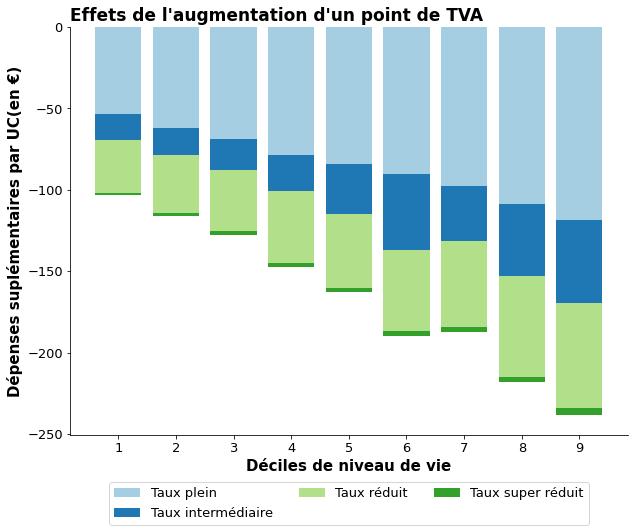

In [ ]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires par UC(en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf',
                 errors = None)

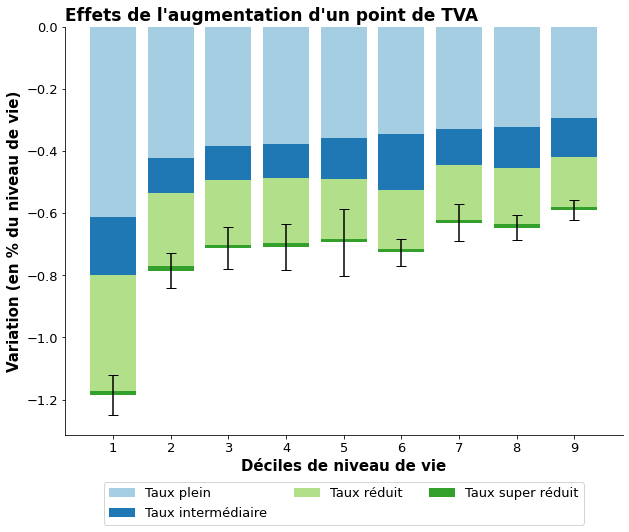

In [ ]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf',
                 errors = 'errors'
                 )

#### Décomposition actifs / inactifs

In [ ]:
difference_by_decile_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 1], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
difference_by_decile_actifs['taux_epargne_actifs'] = 1 - difference_by_decile_actifs['depenses_tot'] / difference_by_decile_actifs['rev_disponible']

In [ ]:
difference_by_decile_actifs[['taux_epargne_actifs']]

,taux_epargne_actifs
quantile_indiv_niveau_vie,
1,-0.661274
2,-0.134282
3,-0.061084
4,-0.035895
5,0.000139
6,-0.062194
7,0.098574
8,0.095612
9,0.175287


In [ ]:
for taux in liste_taux:
   difference_by_decile_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_actifs['niveau_de_vie'] * 100
difference_by_decile_actifs['Taux_effort_total'] = difference_by_decile_actifs['depenses_totales_par_uc'] / difference_by_decile_actifs['niveau_de_vie'] * 100

In [ ]:
# Bootstrap 

results_bootstrap_actifs = bootstrap_weighted_mean_by_decile(df.loc[df['actifs'] == 1], 'pondmen', 'quantile_indiv_niveau_vie', B = 10000)
errors_actifs = pd.DataFrame(pd.DataFrame(results_bootstrap_actifs).std(axis = 0))
errors_actifs = errors_actifs.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_actifs = errors_actifs.reset_index().rename({'index' : 'quantile_indiv_niveau_vie'}, axis = 1).set_index('quantile_indiv_niveau_vie')
errors_actifs['errors'] = 1.96 * errors_actifs['std']
difference_by_decile_actifs = difference_by_decile_actifs.merge(errors_actifs, left_index = True, right_index = True)

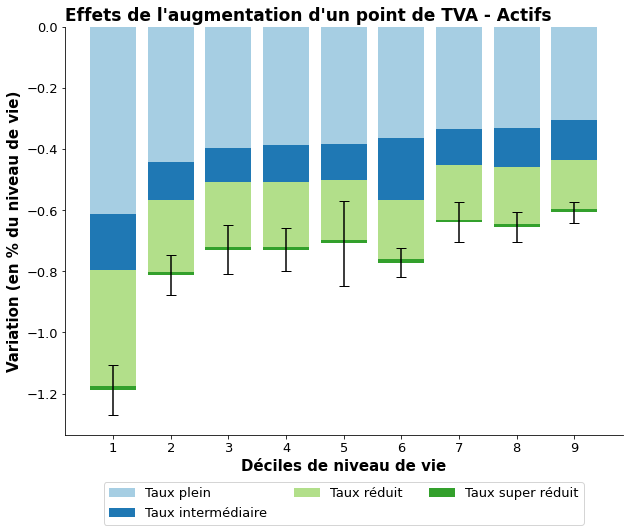

In [ ]:
stacked_bar_plot(difference_by_decile_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Actifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only.pdf',
                 errors = 'errors')

In [ ]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 0], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                    )
difference_by_decile_not_actifs['taux_epargne_inactifs'] = 1 - difference_by_decile_not_actifs['depenses_tot'] / difference_by_decile_not_actifs['rev_disponible']

In [ ]:
difference_by_decile_not_actifs[['taux_epargne_inactifs']]

,taux_epargne_inactifs
quantile_indiv_niveau_vie,
1,-0.687910
2,-0.059006
3,0.013932
4,-0.040210
5,0.037933
6,0.125424
7,0.134970
8,0.133863
9,0.277857


In [ ]:
for taux in liste_taux:
   difference_by_decile_not_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_not_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_not_actifs['niveau_de_vie'] * 100
difference_by_decile_not_actifs['Taux_effort_total'] = difference_by_decile_not_actifs['depenses_totales_par_uc'] / difference_by_decile_not_actifs['niveau_de_vie'] * 100

In [ ]:
# Bootstrap 

results_bootstrap_inactifs = bootstrap_weighted_mean_by_decile(df.loc[df['actifs'] == 0], 'pondmen', 'quantile_indiv_niveau_vie', B = 10000)
errors_inactifs = pd.DataFrame(pd.DataFrame(results_bootstrap_inactifs).std(axis = 0))
errors_inactifs = errors_inactifs.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_inactifs = errors_inactifs.reset_index().rename({'index' : 'quantile_indiv_niveau_vie'}, axis = 1).set_index('quantile_indiv_niveau_vie')
errors_inactifs['errors'] = 1.96 * errors_inactifs['std']
difference_by_decile_not_actifs = difference_by_decile_not_actifs.merge(errors_inactifs, left_index = True, right_index = True)

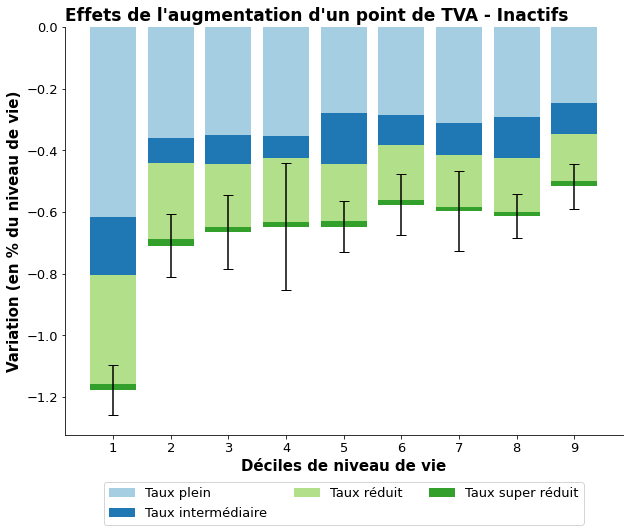

In [ ]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Inactifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_not_actifs.pdf',
                 errors = 'errors')

In [ ]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import double_stacked_bar_plot

In [ ]:
difference_by_decile_not_actifs

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,taux_epargne_inactifs,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
quantile_indiv_niveau_vie,,,,,,,,,,,,,,,
1,21404.856012,14862.073549,-96.706903,12681.278076,8211.276542,-50.629498,-15.319525,-29.222708,-1.535150,-0.687910,-0.616585,-0.186567,-0.355885,-0.018696,-1.177733
2,21536.323757,16142.149873,-105.104092,20336.358193,14822.664455,-53.499709,-11.837419,-36.754674,-3.012280,-0.059006,-0.360932,-0.079860,-0.247963,-0.020322,-0.709077
3,23319.903007,18220.856860,-119.295993,23649.394208,17953.877365,-62.716593,-17.211576,-36.692707,-2.675114,0.013932,-0.349321,-0.095866,-0.204372,-0.014900,-0.664458
4,28408.767187,21431.197848,-134.605003,27310.605343,20773.598875,-73.530066,-14.999028,-42.670319,-3.405628,-0.040210,-0.353959,-0.072202,-0.205406,-0.016394,-0.647962
5,30098.540841,22392.808254,-151.937404,31285.280952,23467.546821,-65.586606,-38.900573,-43.518804,-3.931302,0.037933,-0.279478,-0.165763,-0.185442,-0.016752,-0.647436
6,30947.815937,22839.128617,-150.848241,35386.080754,26134.141374,-74.602508,-25.117585,-47.213606,-3.914561,0.125424,-0.285460,-0.096110,-0.180659,-0.014979,-0.577208
7,34849.443268,25526.500430,-177.478170,40286.989071,29759.175296,-92.608827,-31.174770,-49.888039,-3.806533,0.134970,-0.311194,-0.104757,-0.167639,-0.012791,-0.596381
8,40512.049944,28855.327756,-207.314264,46773.243242,33806.657844,-99.063966,-44.836836,-58.981074,-4.432356,0.133863,-0.293031,-0.132627,-0.174466,-0.013111,-0.613235
9,40169.627168,28836.662339,-208.468981,55625.558151,40290.791106,-99.728939,-40.622335,-61.170193,-6.947426,0.277857,-0.247523,-0.100823,-0.151822,-0.017243,-0.517411


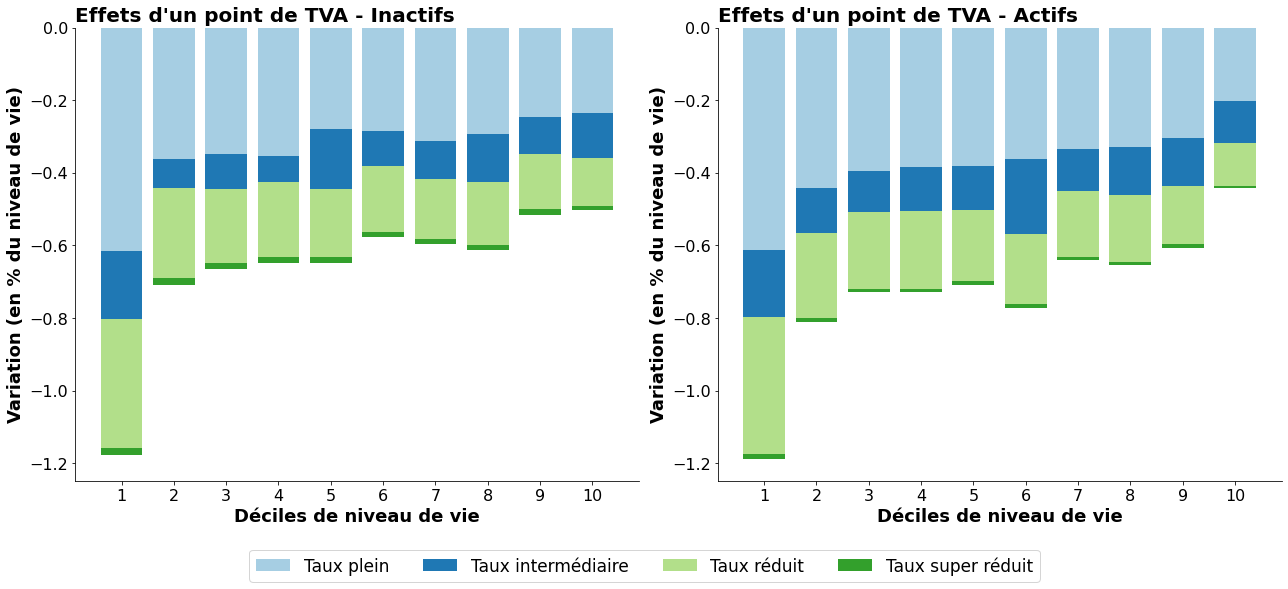

In [ ]:
double_stacked_bar_plot(difference_by_decile_not_actifs,
                        difference_by_decile_actifs, 
                        variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                        labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                        title1 = "Effets d'un point de TVA - Inactifs",
                        title2 = "Effets d'un point de TVA - Actifs",
                        xlabel = 'Déciles de niveau de vie' ,
                        ylabel = 'Variation (en % du niveau de vie)',
                        colors = list(sns.color_palette("Paired")),
                        savefig = True,
                        outfile = 'Taux_effort_actifs_not_actifs.pdf')

In [ ]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'
columns_list = ['Taux_effort_total','std','errors'] + ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux]
to_graph_all = difference_by_decile[columns_list] 
to_graph_all.to_csv(os.path.join(output_data_path,'to_graph_all.csv'), sep = ',', index = True)

# Actifs en emploi uniquement
to_graph_actifs_only = difference_by_decile_actifs[columns_list]
to_graph_actifs_only.to_csv(os.path.join(output_data_path,'to_graph_actifs_only.csv'), sep = ',', index = True)

# Inactifs sans emploi
to_graph_not_actifs = difference_by_decile_not_actifs[columns_list]
to_graph_not_actifs.to_csv(os.path.join(output_data_path,'to_graph_not_actifs.csv'), sep = ',', index = True)

## Analyse par vingtième de niveau de vie

In [ ]:
difference_indiv['vingtieme_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,21), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['vingtieme_indiv_niveau_vie'] = difference_indiv['vingtieme_indiv_niveau_vie'].astype(int)

In [ ]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_by_vingtieme = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'vingtieme_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_totales','niveau_de_vie','rev_disponible','ocde10'] +
                                                   ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_vingtieme['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_vingtieme['depenses_tva_taux_{}'.format(taux)] / difference_by_vingtieme['rev_disponible'] * 100
difference_by_vingtieme['Taux_effort_total'] = difference_by_vingtieme['depenses_totales'] / difference_by_vingtieme['rev_disponible'] * 100

In [ ]:
difference_by_vingtieme

,depenses_tot,depenses_totales,niveau_de_vie,rev_disponible,ocde10,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
vingtieme_indiv_niveau_vie,,,,,,,,,,,,,,
1,27408.415863,-185.589708,6877.359291,13252.490707,1.860574,-92.669902,-29.534567,-61.509618,-1.875532,-0.699264,-0.222861,-0.464136,-0.014152,-1.400414
2,29803.807266,-205.288787,10550.153577,21058.291551,1.993634,-105.947102,-30.744119,-65.899972,-2.697566,-0.503113,-0.145995,-0.312941,-0.012810,-0.974860
3,31658.602343,-220.758584,13891.916098,27576.805194,1.985054,-121.798423,-28.836626,-66.601853,-3.521727,-0.441670,-0.104568,-0.241514,-0.012771,-0.800523
4,32243.557325,-223.089411,15654.144797,29470.417070,1.880948,-117.667851,-33.079696,-68.771362,-3.570651,-0.399274,-0.112247,-0.233357,-0.012116,-0.756994
5,33068.379578,-222.878856,17166.138926,31290.526049,1.822998,-121.195035,-32.037995,-66.705816,-2.940118,-0.387322,-0.102389,-0.213182,-0.009396,-0.712289
6,35533.976472,-244.360596,18672.207953,34276.163644,1.835570,-127.732101,-39.908724,-73.300502,-3.419376,-0.372656,-0.116433,-0.213853,-0.009976,-0.712917
7,40452.008352,-280.895487,20124.930896,37351.438744,1.857106,-146.963910,-45.314665,-84.258906,-4.358063,-0.393463,-0.121320,-0.225584,-0.011668,-0.752034
8,38259.763696,-263.391102,21424.513477,38571.110441,1.799702,-142.315684,-38.674153,-79.041992,-3.359207,-0.368970,-0.100267,-0.204925,-0.008709,-0.682871
9,40652.171817,-284.277717,22830.156540,41176.505587,1.803408,-143.557675,-56.025503,-80.385086,-4.309438,-0.348640,-0.136062,-0.195221,-0.010466,-0.690388


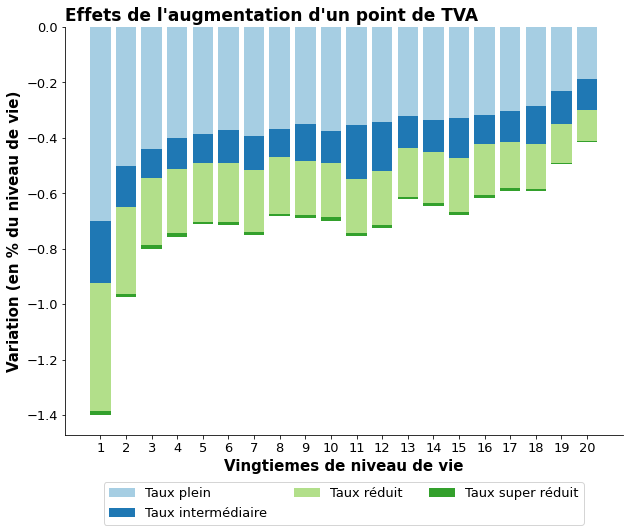

In [ ]:
stacked_bar_plot(difference_by_vingtieme, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Vingtiemes de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = '')